## Import packages

In [4]:
%matplotlib inline
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from CFModel import CFModel

## Define constants

In [5]:
RATINGS_CSV_FILE = './input/rating_result.csv'
MODEL_WEIGHTS_FILE = 'recipe_weights.h5'
K_FACTORS = 120
RNG_SEED = 144653

## Load Recipe data

In [6]:
ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep=',', 
                      encoding='utf-8', 
                      usecols=['id','userid', 'recipeid', 'rating'])
max_userid = ratings['userid'].max() + 1
max_recipeid = ratings['recipeid'].max() + 1
print(len(ratings), 'ratings loaded.')

(1000000, 'ratings loaded.')


## Create training set

In [7]:
shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)
Users = shuffled_ratings['userid'].values
print('Users:', Users, ', shape =', Users.shape)
Recipe = shuffled_ratings['recipeid'].values
print('Recipes:', Recipe, ', shape =', Recipe.shape)
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

('Users:', array([  599,   414,  5950, ..., 11751,  6257,  8880]), ', shape =', (1000000,))
('Recipes:', array([1755, 2361,  832, ..., 2014,  661, 1691]), ', shape =', (1000000,))
('Ratings:', array([5, 5, 5, ..., 5, 5, 5]), ', shape =', (1000000,))


## Define model

In [8]:
model = CFModel(max_userid, max_recipeid, K_FACTORS)
model.compile(loss='mse', optimizer='adamax')

CFModel.py:25: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  self.add(Merge([P, Q], mode='dot', dot_axes=1))


## Train model

In [9]:
callbacks = [EarlyStopping('val_loss', patience=2),
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
history = model.fit([Users, Recipe], Ratings, nb_epoch=10, validation_split=.1, verbose=1, callbacks=callbacks)

/home/dislab/anaconda2/lib/python2.7/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 900000 samples, validate on 100000 samples
Epoch 1/10
900000/900000 [==============================] - 704s 782us/step - loss: 18.3079 - val_loss: 7.4669
Epoch 2/10
900000/900000 [==============================] - 731s 813us/step - loss: 3.4053 - val_loss: 1.4020
Epoch 3/10
900000/900000 [==============================] - 732s 813us/step - loss: 0.7135 - val_loss: 0.4097
Epoch 4/10
900000/900000 [==============================] - 712s 791us/step - loss: 0.2474 - val_loss: 0.1916
Epoch 5/10
900000/900000 [==============================] - 715s 795us/step - loss: 0.1304 - val_loss: 0.1181
Epoch 6/10
900000/900000 [==============================] - 754s 838us/step - loss: 0.0822 - val_loss: 0.0827
Epoch 7/10
900000/900000 [==============================] - 753s 836us/step - loss: 0.0574 - val_loss: 0.0627
Epoch 8/10
900000/900000 [==============================] - 745s 828us/step - loss: 0.0428 - val_loss: 0.0503
Epoch 9/10
900000/900000 [==============================] - 751s 83

In [10]:
[node.op.name for node in model.inputs]

[u'embedding_1_input', u'embedding_2_input']

In [11]:
[node.op.name for node in model.outputs]

[u'merge_1/ExpandDims']

In [12]:
from keras import backend as K
from tensorflow.python.tools import optimize_for_inference_lib
from tensorflow.python.tools import freeze_graph

MODEL_NAME = "recipe.pb"
def export_model(saver, model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'out', \
        MODEL_NAME + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'out/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")

export_model(tf.train.Saver(), model, ['embedding_1_input', u'embedding_2_input'], "merge_1/ExpandDims")

INFO:tensorflow:Restoring parameters from out/recipe.pb.chkp
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.
graph saved!


## Plot training and validation RMSE

/home/dislab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


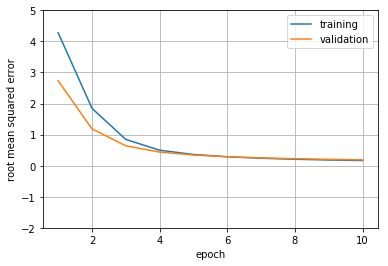

In [13]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = loss.ix[:,:].plot(x='epoch', grid=True)
ax.set_ylabel("root mean squared error")
ax.set_ylim([-2.0,5.0]);